In [14]:
import requests
import requests_cache
import pandas as pd
import os
import numpy as np
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

# Setup API token and cache
api_token = os.environ.get('EODHD_API_TOKEN')
requests_cache.install_cache('cache')

In [7]:
def get_stock_data(ticker, start_date, end_date):
    url = f'https://eodhd.com/api/eod/{ticker}'
    query = {
        'api_token': api_token,
        'fmt': 'json',
        'from': start_date,
        'to': end_date
    }

    response = requests.get(url, params=query)
    if response.status_code != 200:
        print(f"Error fetching data for {ticker}: {response.status_code}")
        print(response.text)
        return None

    data = response.json()
    df = pd.DataFrame(data)

    df['date'] = pd.to_datetime(df['date'])

    # Add ticker column
    df['ticker'] = ticker

    return df

In [8]:
def add_52week_high_low(df):
    result_df = df.copy()

    result_df['date'] = pd.to_datetime(result_df['date'])
    result_df = result_df.sort_values('date')

    # Set Date as index for time-based rolling
    result_df = result_df.set_index('date')

    result_df['52w_high'] = result_df['adjusted_close'].rolling(window=252, min_periods=252).max()
    result_df['52w_low'] = result_df['adjusted_close'].rolling(window=252, min_periods=252).min()

    # Reset index if needed
    result_df = result_df.reset_index()

    return result_df

In [9]:
def get_technical_indicator(ticker, indicator, start_date, end_date, **params):
    """Fetch a specific technical indicator for a given ticker"""
    url = f'https://eodhd.com/api/technical/{ticker}'

    query = {
        'api_token': api_token,
        'fmt': 'json',
        'from': start_date,
        'to': end_date,
        'function': indicator
    }

    # Add any additional parameters
    query.update(params)

    response = requests.get(url, params=query)

    if response.status_code != 200:
        print(f"Error fetching {indicator} for {ticker}: {response.status_code}")
        print(response.text)
        return None

    data = response.json()
    df = pd.DataFrame(data)

    # Convert date to datetime
    if 'date' in df.columns:
        df['date'] = pd.to_datetime(df['date'])

    # Rename columns to include the indicator name
    for col in df.columns:
        if col != 'date':
            df.rename(columns={col: f"{indicator}_{col}"}, inplace=True)

    return df

def add_all_technical_indicators(df, ticker, start_date, end_date):
    """Add all technical indicators to the dataframe"""
    # Create a copy of the dataframe
    result_df = df.copy()

    # List of indicators to add
    indicators = [
        {'name': 'sma', 'params': {'period': '50'}},
        {'name': 'ema', 'params': {'period': '50'}},
        {'name': 'wma', 'params': {'period': '50'}},
        {'name': 'volatility', 'params': {'period': '50'}},
        {'name': 'rsi', 'params': {'period': '14'}},
        {'name': 'slope', 'params': {'period': '50'}},
        {'name': 'dmi', 'params': {'period': '14'}},
        {'name': 'adx', 'params': {'period': '14'}},
        {'name': 'atr', 'params': {'period': '14'}},
        {'name': 'cci', 'params': {'period': '20'}},
        {'name': 'bbands', 'params': {'period': '20'}}
    ]

    # Special cases with more parameters
    stochastic_df = get_technical_indicator(ticker, 'stochastic', start_date, end_date,
                                           fast_kperiod=14, slow_dperiod=3, slow_kperiod=3)
    macd_df = get_technical_indicator(ticker, 'macd', start_date, end_date,
                                     fast_period=12, slow_period=26, signal_period=9)
    sar_df = get_technical_indicator(ticker, 'sar', start_date, end_date,
                                    acceleration='0.02', maximum='0.2')

    # Add the special cases to the result if they exist
    if stochastic_df is not None:
        result_df = pd.merge(result_df, stochastic_df, on='date', how='left')
    if macd_df is not None:
        result_df = pd.merge(result_df, macd_df, on='date', how='left')
    if sar_df is not None:
        result_df = pd.merge(result_df, sar_df, on='date', how='left')

    # Add the rest of the indicators
    for indicator in indicators:
        indicator_df = get_technical_indicator(ticker, indicator['name'], start_date, end_date, **indicator['params'])
        if indicator_df is not None:
            result_df = pd.merge(result_df, indicator_df, on='date', how='left')

    return result_df

In [10]:
tickers = ["MSFT.US", "AAPL.US", "META.US", "GOOGL.US", 'NVDA.US', 'AVGO.US', 'AMZN.US']
start_date = "2019-01-01"
end_date = "2025-08-15"

# Dictionary to store dataframes for each ticker
stock_dfs = {}

# Process each ticker
for ticker in tickers:
    print(f"Processing {ticker}...")

    # Get extended data for 52-week calculations
    extended_df = get_stock_data(ticker, start_date, end_date)

    if extended_df is not None:
        # Add 52-week high and low
        extended_df = add_52week_high_low(extended_df)

        # Filter to include data from 2022 until today
        df_filtered = extended_df[extended_df['date'] >= pd.to_datetime(start_date)].copy()

        # Add technical indicators
        df_with_indicators = add_all_technical_indicators(df_filtered, ticker, start_date, end_date)

        # Store in dictionary
        stock_dfs[ticker] = df_with_indicators

        # Display sample
        print(f"Sample data for {ticker}:")
        display(df_with_indicators.head())
        print(f"Shape: {df_with_indicators.shape}")
        print("\n")
    else:
        print(f"Failed to get data for {ticker}\n")

# Combine all dataframes
all_stocks_df = pd.concat(stock_dfs.values(), ignore_index=True)

# Sort by ticker and date
all_stocks_df = all_stocks_df.sort_values(['ticker', 'date'])

Processing MSFT.US...
Sample data for MSFT.US:


,date,open,high,low,close,adjusted_close,volume,ticker,52w_high,52w_low,...,volatility_volatility,rsi_rsi,slope_slope,dmi_dmi,adx_adx,atr_atr,cci_cci,bbands_uband,bbands_mband,bbands_lband
0,2019-01-02,99.55,101.75,98.94,101.12,94.8361,35329300,MSFT.US,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2019-01-03,100.10,100.19,97.20,97.40,91.3473,42579100,MSFT.US,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2019-01-04,99.72,102.51,98.93,101.93,95.5957,44060600,MSFT.US,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2019-01-07,101.64,103.27,100.98,102.06,95.7177,35656100,MSFT.US,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-01-08,103.04,103.97,101.71,102.80,96.4117,31514400,MSFT.US,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Shape: (1664, 29)


Processing AAPL.US...
Sample data for AAPL.US:


,date,open,high,low,close,adjusted_close,volume,ticker,52w_high,52w_low,...,volatility_volatility,rsi_rsi,slope_slope,dmi_dmi,adx_adx,atr_atr,cci_cci,bbands_uband,bbands_mband,bbands_lband
0,2019-01-02,154.89,158.85,154.23,157.92,37.5752,148158800,AAPL.US,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2019-01-03,143.98,145.72,142.00,142.19,33.8324,365248800,AAPL.US,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2019-01-04,144.53,148.55,143.80,148.26,35.2767,234428400,AAPL.US,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2019-01-07,148.70,148.83,145.90,147.93,35.1982,219111200,AAPL.US,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-01-08,149.56,151.82,148.52,150.75,35.8692,164101200,AAPL.US,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Shape: (1664, 29)


Processing META.US...
Sample data for META.US:


,date,open,high,low,close,adjusted_close,volume,ticker,52w_high,52w_low,...,volatility_volatility,rsi_rsi,slope_slope,dmi_dmi,adx_adx,atr_atr,cci_cci,bbands_uband,bbands_mband,bbands_lband
0,2019-01-02,128.99,137.51,128.56,135.68,134.9397,28146189,META.US,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2019-01-03,134.69,137.17,131.12,131.74,131.0212,22717949,META.US,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2019-01-04,134.01,138.00,133.75,137.95,137.1973,29002061,META.US,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2019-01-07,137.56,138.87,135.91,138.05,137.2968,20089340,META.US,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-01-08,139.89,143.14,139.54,142.53,141.7523,26263789,META.US,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Shape: (1664, 29)


Processing GOOGL.US...
Sample data for GOOGL.US:


,date,open,high,low,close,adjusted_close,volume,ticker,52w_high,52w_low,...,volatility_volatility,rsi_rsi,slope_slope,dmi_dmi,adx_adx,atr_atr,cci_cci,bbands_uband,bbands_mband,bbands_lband
0,2019-01-02,1027.20,1060.79,1025.275,1054.68,52.4196,31867900,GOOGL.US,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2019-01-03,1050.67,1066.26,1022.370,1025.47,50.9678,41959139,GOOGL.US,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2019-01-04,1042.56,1080.00,1036.860,1078.07,53.5822,46028559,GOOGL.US,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2019-01-07,1080.97,1082.70,1062.640,1075.92,53.4753,47453339,GOOGL.US,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-01-08,1086.00,1093.35,1068.349,1085.37,53.9450,35413080,GOOGL.US,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Shape: (1664, 29)


Processing NVDA.US...
Sample data for NVDA.US:


,date,open,high,low,close,adjusted_close,volume,ticker,52w_high,52w_low,...,volatility_volatility,rsi_rsi,slope_slope,dmi_dmi,adx_adx,atr_atr,cci_cci,bbands_uband,bbands_mband,bbands_lband
0,2019-01-02,130.64,138.48,130.050,136.22,3.3778,508753595,NVDA.US,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2019-01-03,133.79,135.16,127.693,127.99,3.1737,705551553,NVDA.US,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2019-01-04,130.94,137.73,129.700,136.19,3.3771,585619194,NVDA.US,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2019-01-07,138.50,144.89,136.430,143.40,3.5558,709159193,NVDA.US,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-01-08,146.69,146.78,136.900,139.83,3.4673,786017192,NVDA.US,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Shape: (1665, 29)


Processing AVGO.US...
Sample data for AVGO.US:


,date,open,high,low,close,adjusted_close,volume,ticker,52w_high,52w_low,...,volatility_volatility,rsi_rsi,slope_slope,dmi_dmi,adx_adx,atr_atr,cci_cci,bbands_uband,bbands_mband,bbands_lband
0,2019-01-02,248.85,254.705,246.490,253.51,21.0811,30345530,AVGO.US,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2019-01-03,244.56,246.540,230.333,230.96,19.2060,68579600,AVGO.US,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2019-01-04,234.29,236.450,231.670,233.23,19.3947,54247670,AVGO.US,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2019-01-07,233.65,240.240,230.760,237.98,19.7897,53433060,AVGO.US,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-01-08,240.11,241.900,233.368,236.07,19.6309,36795210,AVGO.US,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Shape: (1665, 29)


Processing AMZN.US...
Sample data for AMZN.US:


,date,open,high,low,close,adjusted_close,volume,ticker,52w_high,52w_low,...,volatility_volatility,rsi_rsi,slope_slope,dmi_dmi,adx_adx,atr_atr,cci_cci,bbands_uband,bbands_mband,bbands_lband
0,2019-01-02,1465.20,1553.36,1460.930,1539.13,76.9565,159662078,AMZN.US,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2019-01-03,1520.01,1538.00,1497.110,1500.28,75.0140,139511438,AMZN.US,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2019-01-04,1530.00,1594.00,1518.310,1575.39,78.7695,183651497,AMZN.US,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2019-01-07,1602.31,1634.56,1589.185,1629.51,81.4755,159864258,AMZN.US,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-01-08,1664.69,1676.61,1616.610,1656.58,82.8290,177628558,AMZN.US,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Shape: (1665, 29)




In [11]:
# Calculate future returns as percentage changes from the current close price
all_stocks_df["ret_1w"] = all_stocks_df.groupby("ticker")['close'].shift(-5) / all_stocks_df['close'] - 1
all_stocks_df["ret_1m"] = all_stocks_df.groupby("ticker")['close'].shift(-21) / all_stocks_df['close'] - 1
all_stocks_df["ret_3m"] = all_stocks_df.groupby("ticker")['close'].shift(-63) / all_stocks_df['close'] - 1

# Define labeling function
def label_return(r, threshold=0.05):
    if pd.isna(r):
        return None
    if r > threshold:
        return "Up"
    elif r < -1 * threshold:
        return "Down"
    else:
        return "Neutral"

# Apply labeling for each target
all_stocks_df["target_1w_class"] = all_stocks_df["ret_1w"].apply(label_return)
all_stocks_df["target_1m_class"] = all_stocks_df["ret_1m"].apply(label_return)
all_stocks_df["target_3m_class"] = all_stocks_df["ret_3m"].apply(label_return)

In [12]:
all_stocks_df = all_stocks_df.copy().dropna()

all_stocks_df['52w_high'] = (
        (all_stocks_df['52w_high'] - all_stocks_df['adjusted_close']) / all_stocks_df['adjusted_close'] * 100
)

all_stocks_df['52w_low'] = (
        (all_stocks_df['52w_low'] - all_stocks_df['adjusted_close']) / all_stocks_df['adjusted_close'] * 100
)

all_stocks_df['sma_sma'] = (
        (all_stocks_df['sma_sma'] - all_stocks_df['adjusted_close']) / all_stocks_df['adjusted_close'] * 100
)

all_stocks_df['ema_ema'] = (
        (all_stocks_df['ema_ema'] - all_stocks_df['adjusted_close']) / all_stocks_df['adjusted_close'] * 100
)

all_stocks_df['wma_wma'] = (
        (all_stocks_df['ema_ema'] - all_stocks_df['adjusted_close']) / all_stocks_df['adjusted_close'] * 100
)

all_stocks_df['sar_sar'] = (
        (all_stocks_df['sar_sar'] - all_stocks_df['adjusted_close']) / all_stocks_df['adjusted_close'] * 100
)

all_stocks_df['rsi_rsi'] = np.select(
    [
        all_stocks_df['rsi_rsi'] > 70,
        all_stocks_df['rsi_rsi'] < 30
    ],
    [1, -1],
    default=0
).astype('int8')

all_stocks_df['stochastic_k_values'] = np.select(
    [
        all_stocks_df['stochastic_k_values'] > 80,
        all_stocks_df['stochastic_k_values'] < 20
    ],
    [1, -1],
    default=0
).astype('int8')

all_stocks_df['stochastic_d_values'] = np.select(
    [
        all_stocks_df['stochastic_d_values'] > 80,
        all_stocks_df['stochastic_d_values'] < 20
    ],
    [1, -1],
    default=0
).astype('int8')

all_stocks_df['cci_cci'] = np.select(
    [
        all_stocks_df['cci_cci'] > 100,
        all_stocks_df['cci_cci'] < -100
    ],
    [1, -1],
    default=0
).astype('int8')

all_stocks_df['macd_macd'] = (
        (all_stocks_df['macd_macd'] - all_stocks_df['macd_signal']) / all_stocks_df['macd_signal'] * 100
)
all_stocks_df.drop(['macd_signal', 'macd_divergence'], axis=1, inplace=True)

# Calculate absolute distances
dist_u = (all_stocks_df['adjusted_close'] - all_stocks_df['bbands_uband']).abs()
dist_m = (all_stocks_df['adjusted_close'] - all_stocks_df['bbands_mband']).abs()
dist_l = (all_stocks_df['adjusted_close'] - all_stocks_df['bbands_lband']).abs()

# Create a DataFrame of distances
distances = pd.concat([dist_u, dist_m, dist_l], axis=1)
distances.columns = [1, 0, -1]  # Map to desired output

# Find the column (signal) with min distance for each row
all_stocks_df['bbands_uband'] = distances.idxmin(axis=1)
all_stocks_df.rename(
    columns={'bbands_uband': 'bbands_bband'},
    inplace=True
)
all_stocks_df.drop(['bbands_mband', 'bbands_lband'], axis=1, inplace=True)

In [15]:
def return_model_and_results(df, exclude_ind=None):

    # Ensure sorted by time to allow chronological split
    df = df.sort_values(['date']).reset_index(drop=True)

    # Early split: define training and testing dataframes (chronological 80/20)
    n_total = len(df)
    n_train = int(n_total * 0.80)
    train_df = df.iloc[:n_train].copy()
    test_df = df.iloc[n_train:].copy()

    # Drop all NA from the training dataframe
    train_df = train_df.dropna()
    test_df = test_df.dropna()

    train_df.to_csv('train.csv')
    test_df.to_csv('test.csv')

    # Select your features: remove target columns and all columns that we do not want to use as features
    excluded_cols = [
        "target_1w_class", "target_1m_class", "target_3m_class",'ret_1w', 'ret_1m', 'ret_3m',
        "ticker", 'open', 'high', 'low', 'close', 'adjusted_close', 'volume', 'date'
    ]

    if exclude_ind:
        excluded_cols.extend(exclude_ind)
        # print(exclude_ind)

    # Build features for train and test from their respective dataframes
    features_train = train_df.drop(columns=[col for col in excluded_cols if col in train_df.columns])
    features_test = test_df.drop(columns=[col for col in excluded_cols if col in test_df.columns])

    features_test.to_csv('test_features.csv')
    features_train.to_csv('train_features.csv')

    feature_names = features_train.columns

    # Prepare label encoders with fixed classes to avoid unseen-class issues
    le_1w, le_1m, le_3m = LabelEncoder(), LabelEncoder(), LabelEncoder()
    fixed_classes = ['Down', 'Neutral', 'Up']
    le_1w.fit(fixed_classes)
    le_1m.fit(fixed_classes)
    le_3m.fit(fixed_classes)

    # Helper to train on train_df and evaluate on test_df for a given target column
    def train_and_eval_for_target(target_col, label_encoder):
        # Training labels/features
        y_train_raw = train_df[target_col]
        X_train = features_train
        # Since train_df was fully dropna(), both X_train and y_train_raw are non-null
        Y_train = label_encoder.transform(y_train_raw)

        # Testing labels/features: use test_df to provide accuracy (filter rows with available target)
        y_test_raw = test_df[target_col]
        valid_test_idx = y_test_raw.dropna().index
        if len(valid_test_idx) == 0:
            # No labels available on test set for this horizon
            model = xgb.XGBClassifier(use_label_encoder=False, eval_metric="mlogloss", random_state=42)
            model.fit(X_train, Y_train)
            return model, "No test labels available.", float('nan')

        X_test = features_test.loc[valid_test_idx]
        y_test = y_test_raw.loc[valid_test_idx]
        Y_test = label_encoder.transform(y_test)

        model = xgb.XGBClassifier(use_label_encoder=False, eval_metric="mlogloss", random_state=42)
        model.fit(X_train, Y_train)
        y_pred = model.predict(X_test)

        # Build report/accuracy using test dataframe
        # target_names derived from fixed_classes to ensure order
        cl_report = classification_report(Y_test, y_pred, target_names=label_encoder.classes_, zero_division=0)
        # print(f"Classification report for {target_col}:")
        # print(cl_report)
        acc_score = accuracy_score(Y_test, y_pred)
        return model, cl_report, acc_score

    # Train models for each target using the new split logic
    model_1w, cl_report_1w, acc_score_1w = train_and_eval_for_target("target_1w_class", le_1w)
    model_1m, cl_report_1m, acc_score_1m = train_and_eval_for_target("target_1m_class", le_1m)
    model_3m, cl_report_3m, acc_score_3m = train_and_eval_for_target("target_3m_class", le_3m)

    def get_top_feature_importances(model):
        importances = model.feature_importances_
        return importances

    features_importance_1w = get_top_feature_importances(model_1w)
    features_importance_1m = get_top_feature_importances(model_1m)
    features_importance_3m = get_top_feature_importances(model_3m)

    results_to_return = \
        {
        '1w':
            {
                'model': model_1w,
                'feature_names': feature_names,
                'acc_score': acc_score_1w,
                'cl_report': cl_report_1w,
                'features_importance': features_importance_1w
            },
        '1m': {
            'model': model_1m,
            'feature_names': feature_names,
            'acc_score': acc_score_1m,
            'cl_report': cl_report_1m,
            'features_importance': features_importance_1m
            },
        '3m': {
            'model': model_3m,
            'feature_names': feature_names,
            'acc_score': acc_score_3m,
            'cl_report': cl_report_3m,
            'features_importance': features_importance_3m
            }
        }

    return results_to_return

results = return_model_and_results(all_stocks_df)
# results
print(results['1w']['acc_score'])
print(results['1m']['acc_score'])
print(results['3m']['acc_score'])

0.6657852987837123
0.3643574828133263
0.41459545214172394


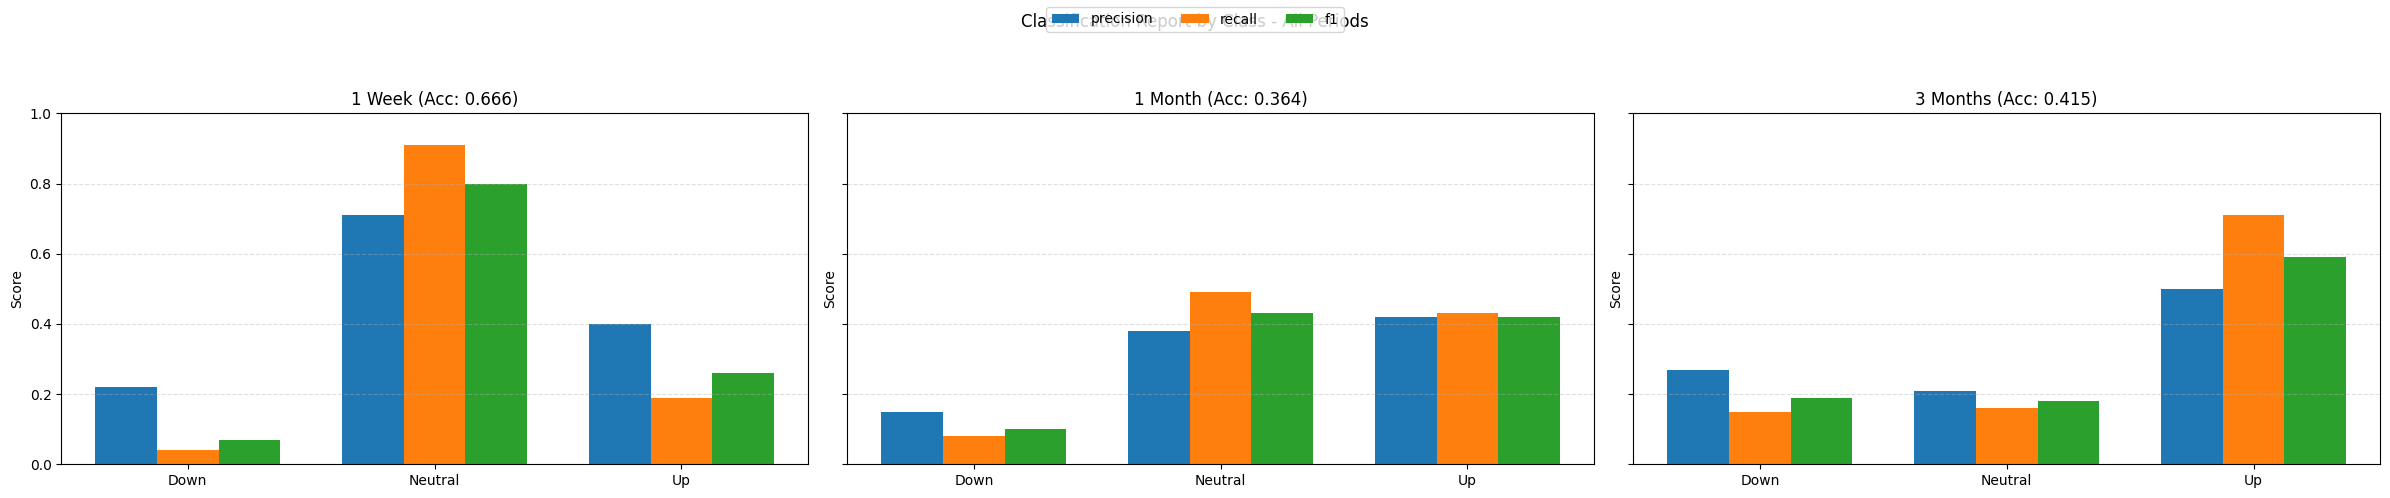

In [16]:
def parse_classification_report(report_str):
    lines = [l.strip() for l in report_str.strip().splitlines() if l.strip()]
    rows = []
    header_found = False
    for l in lines:
        if not header_found and l.lower().startswith("precision"):
            header_found = True
            continue
        if any(l.lower().startswith(x) for x in ["accuracy", "macro avg", "weighted avg"]):
            continue
        parts = l.split()
        if len(parts) == 5:
            cls, prec, rec, f1, supp = parts
            rows.append((cls, float(prec), float(rec), float(f1), int(supp)))
    return pd.DataFrame(rows, columns=["class", "precision", "recall", "f1", "support"])

def plot_classification_report_bars(df, title):
    metrics = ["precision", "recall", "f1"]
    x = np.arange(len(df))
    width = 0.25
    offsets = np.linspace(-width, width, num=len(metrics))
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

    plt.figure(figsize=(8, 5))
    for i, m in enumerate(metrics):
        plt.bar(x + offsets[i], df[m].values, width, label=m, color=colors[i])
    plt.xticks(x, df["class"].values)
    plt.ylim(0, 1)
    plt.ylabel("Score")
    plt.title(title)
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.show()

def plot_classification_reports_subplots(cr_items, results_dict):
    """
    Plot multiple classification report DataFrames as subplots in a single figure.
    cr_items: list of tuples (label, df, period_key)
    results_dict: dict containing metrics including 'acc_score' per period_key
    """
    # Filter out None DataFrames
    valid = [(label, df, key) for (label, df, key) in cr_items if df is not None]
    if not valid:
        print("No classification reports to plot.")
        return

    metrics = ["precision", "recall", "f1"]
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
    n = len(valid)

    fig, axs = plt.subplots(1, n, figsize=(max(8*n, 8), 5), sharey=True)
    if n == 1:
        axs = [axs]

    for ax, (label, df, key) in zip(axs, valid):
        x = np.arange(len(df))
        width = 0.25
        offsets = np.linspace(-width, width, num=len(metrics))
        for i, m in enumerate(metrics):
            ax.bar(x + offsets[i], df[m].values, width, label=m, color=colors[i])
        ax.set_xticks(x)
        ax.set_xticklabels(df["class"].values)
        ax.set_ylim(0, 1)
        acc = None
        if key in results_dict and isinstance(results_dict[key], dict):
            acc = results_dict[key].get('acc_score', None)
        title = f"{label} (Acc: {acc:.3f})" if acc is not None else label
        ax.set_title(title)
        ax.set_ylabel("Score")
        ax.grid(axis='y', linestyle='--', alpha=0.4)

    # Use a single legend for all subplots
    handles, labels = axs[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', ncol=len(metrics))
    fig.suptitle("Classification Report by Class - All Periods")
    plt.tight_layout(rect=[0, 0, 1, 0.92])
    plt.show()

cr_1w_df = parse_classification_report(results['1w']['cl_report']) if '1w' in results else None
cr_1m_df = parse_classification_report(results['1m']['cl_report']) if '1m' in results else None
cr_3m_df = parse_classification_report(results['3m']['cl_report']) if '3m' in results else None

# Combined plot with subplots for all available periods
plot_classification_reports_subplots([
    ("1 Week", cr_1w_df, '1w'),
    ("1 Month", cr_1m_df, '1m'),
    ("3 Months", cr_3m_df, '3m'),
], results)

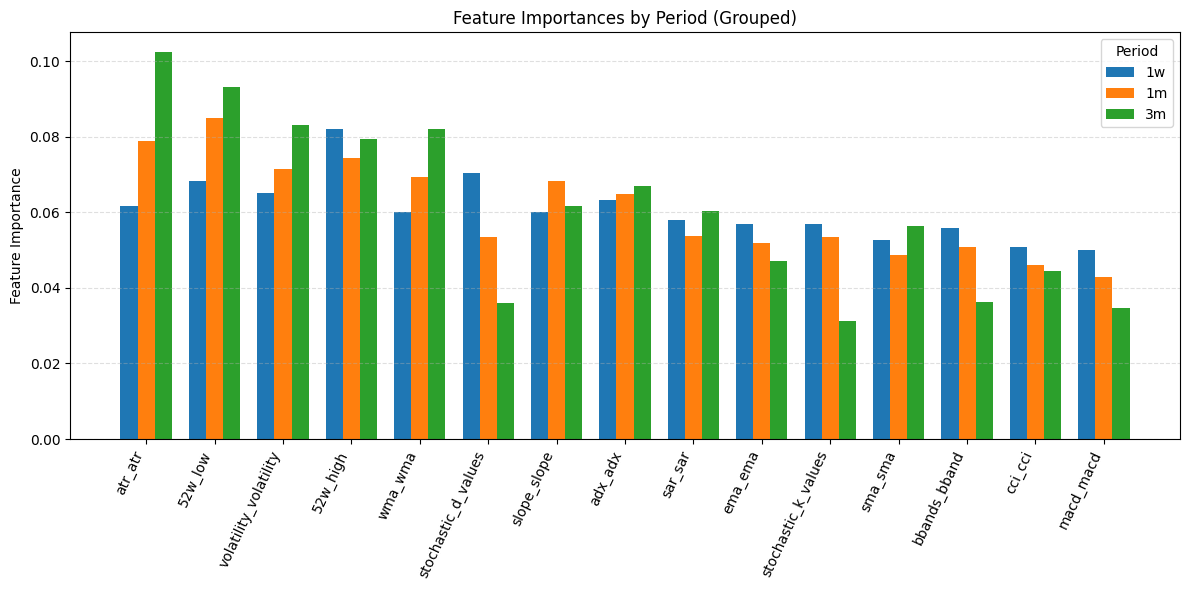

In [17]:
ef plot_grouped_feature_importances(results_dict, top_n=15):
    periods = ['1w', '1m', '3m']
    # Ensure all periods exist
    periods = [p for p in periods if p in results_dict]
    if not periods:
        print("No valid periods found in results.")
        return

    # Assume feature names are aligned across periods
    feature_names = list(results_dict[periods[0]]['feature_names'])
    data = {'feature': feature_names}
    for p in periods:
        data[p] = results_dict[p]['features_importance']

    df_imp = pd.DataFrame(data)
    df_imp['max_imp'] = df_imp[periods].max(axis=1)
    df_top = df_imp.sort_values('max_imp', ascending=False).head(top_n)

    x = np.arange(len(df_top))
    width = 0.25
    offsets = np.linspace(-width, width, num=len(periods))

    plt.figure(figsize=(max(12, top_n * 0.6), 6))
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

    for i, p in enumerate(periods):
        plt.bar(x + offsets[i], df_top[p].values, width, label=p, color=colors[i % len(colors)])

    plt.xticks(x, df_top['feature'].values, rotation=65, ha='right')
    plt.ylabel('Feature Importance')
    plt.title('Feature Importances by Period (Grouped)')
    plt.legend(title='Period')
    plt.grid(axis='y', linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.show()

plot_grouped_feature_importances(results, top_n=15)